In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
import datetime

matplotlib.style.use('ggplot')

In [3]:
from PortfolioConstruction.factor import construct_factor, calc_momentum_ret, calc_beta_ret
from PortfolioConstruction.performance import calc_performance, calc_cum_returns, plot_corr, plot_perf

In [4]:
# Directories
OUTPUT_DIR = '../Outputs/equity/'
INPUT_DIR = '../Data/country_data/'
MACRO_DIR = '../Data/macro_factors/'

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'

# Purpose of Notebook
Construction of DM+EM country factors. Extending EM universe to include DM countries.

7 EM countries are added: Australia, New Zealand, France, Germany, Italy, Japan, UK, US.

# Load Data & Clean to Weekly

## EM+DM Equity ETFs

In [5]:
# Load equity ETF log returns - EM
equity_rets_w = pd.read_pickle(OUTPUT_DIR + 'equity_etf_returns_weekly.pkl')

# Load ETF returns for Equities
equity_etfs_DM = pd.read_excel(INPUT_DIR + 'ETF_close_price.xlsx', sheet_name = 'DM', index_col=0)
equity_etfs_DM.index = pd.to_datetime(equity_etfs_DM.index)
equity_etfs_DM = equity_etfs_DM.resample('W').last()
equity_rets_DM = np.log(equity_etfs_DM).diff()
equity_rets_DM = equity_rets_DM.dropna()

DM_countries = ['Australia', 'New Zealand', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']
equity_rets_DM = equity_rets_DM[DM_countries]
equity_rets_DM = equity_rets_DM[(equity_rets_DM.index>=start_date) & (equity_rets_DM.index<=end_date)]

# Combine EM and DM
equity_rets_all = pd.concat([equity_rets_w, equity_rets_DM], axis=1)

In [6]:
# Get all countries in a list
all_countries = list(equity_rets_w.columns.values) + DM_countries

## Market Cap

In [7]:
# Load market cap data for countries
country_mkt_cap = pd.read_csv(INPUT_DIR + 'country_market_caps.csv',skiprows=4)
country_mkt_cap = country_mkt_cap[country_mkt_cap.columns[~country_mkt_cap.columns.isin(['Country Code', 'Indicator Name', 'Indicator Code'])]]
country_mkt_cap = country_mkt_cap.T.rename_axis('Date')
country_mkt_cap = country_mkt_cap.rename(columns=country_mkt_cap.iloc[0]).drop(country_mkt_cap.index[0])

# Remove Taiwan since it doesn't exist in the market cap data; change names for Korea, Russia, Egypt for better search
all_countries = np.where(all_countries=='Korea', 'Korea, Rep.', all_countries) 
all_countries = np.where(all_countries=='Russia', 'Russian Federation', all_countries) 
all_countries = np.where(all_countries=='Egypt', 'Egypt, Arab Rep.', all_countries)
all_countries = all_countries[~np.isin(all_countries, 'Taiwan')]
all_countries = np.where(all_countries=='Korea', 'Korea, Rep.', all_countries) 

# Only grab countries in all_countries from country_mkt_cap
country_mkt_cap = country_mkt_cap[all_countries]
country_mkt_cap.index = pd.to_datetime(country_mkt_cap.index, format='%Y')
country_mkt_cap = country_mkt_cap[(country_mkt_cap.index>='2015-01-01') & (country_mkt_cap.index<=end_date)]
country_mkt_cap.rename(columns={'Korea, Rep.': 'Korea', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt'}, inplace=True)
country_mkt_cap = country_mkt_cap.fillna(method='ffill')
country_mkt_cap = country_mkt_cap.append(country_mkt_cap.iloc[-1])
country_mkt_cap.index = pd.date_range('2015', '2022', freq='Y')

# Make market cap df to be in weekly
new_df = pd.DataFrame(index=equity_rets_w.index)
def merge_by_year(df):
    df['year'] = list(df.index.year)
    return df

country_mkt_cap = merge_by_year(new_df).merge(merge_by_year(country_mkt_cap), on=['year'])
country_mkt_cap.index = equity_rets_w.index
del country_mkt_cap['year']

# Missing: Italy and UK Market caps
country_mkt_cap.dropna(axis=1, inplace=True)

## Country PE Ratios

In [8]:
# Load country PE ratios
country_pe = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', skiprows=51)
country_pe_match = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', nrows=50)
country_pe_match = country_pe_match[['Ticker', 'Country']]
country_pe_dict = country_pe_match.set_index('Ticker')['Country'].to_dict()
country_pe_dict = {k+'_Close': v for k, v in country_pe_dict.items()}

country_pe.index = country_pe['Date']
del country_pe['Date']

# Rename columns
country_pe.rename(country_pe_dict, axis=1, inplace=True)
countries_new = list(np.where(all_countries=='Korea, Rep.', 'Korea, Republic Of', all_countries))
for country in ['United Arab Emirates', 'Saudi Arabia', 'Egypt, Arab Rep.', 'Pakistan', 'Qatar']:
    countries_new.remove(country)
country_pe = country_pe[countries_new]
country_pe.rename(columns={'Korea, Republic Of': 'Korea', 'Russian Federation': 'Russia'}, inplace=True)

country_pe.index = pd.to_datetime(country_pe.index)
country_pe = country_pe[(country_pe.index>=start_date) & (country_pe.index<=end_date)]
# Fillna's with previous values
country_pe = country_pe.fillna(method='ffill')

# Convert to weekly
new_df = pd.DataFrame(index=equity_rets_all.index)
def merge_by_year_month(df):
    df['year'] = list(df.index.year)
    df['month'] = list(df.index.month)
    return df

country_pe = merge_by_year_month(new_df).merge(merge_by_year_month(country_pe), on=['year', 'month'])
country_pe.index = equity_rets_all.index
del country_pe['year']
del country_pe['month']

## Market ETF

In [9]:
# Market portfolio: Uses iShares MSCI ACWI ETF
market_etfs = pd.read_csv(INPUT_DIR + 'etf_msci_em_agg_indices.csv',skiprows=5, index_col=0)
market_etfs.columns = ['EEM ETF', 'MSCI EM', 'ACWI ETF']
market_etfs.index = pd.to_datetime(market_etfs.index)

# Market portfolio returns
market_rets_w = market_etfs.resample('W').last()
market_rets_w = np.log(market_rets_w).diff()
market_rets_w = market_rets_w.dropna()

market_rets_w = market_rets_w[(market_rets_w.index>=start_date) & (market_rets_w.index<=end_date)]
market_rets_w['ACWI_cum_rets'] = np.exp(market_rets_w['ACWI ETF'].cumsum())-1

## FF

In [10]:
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)
ff6['Date'] = ff6.index
ff6.index = pd.to_datetime(ff6['Date'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d'))
del ff6['Date']

ff6 = ff6[(ff6.index>='2015-09-01') & (ff6.index<=end_date)]
ff6_rf = np.log(ff6[['RF']]/100*12/52+1)
ff6 = ff6[['SMB', 'HML', 'WML', 'Mkt-RF']]
ff6 = np.log(ff6/100+1)

# Construct EM+DM Country Factor Portfolios

## Small cap portfolio
- Use country_mkt_cap as proxy for low capitalization countries.

## Value portfolio
- Use country_pe as proxy for value. This df contains PE ratios by country index.

## Momentum
- Calculate every week the cumulative trailing weekly returns for $t$-2 to $t$-52 and form three portfolios containing in equal numbers the highest, medium, and lowest momentum countries.

In [11]:
mom_df = calc_momentum_ret(equity_rets_all)

## Beta portfolio
* Calculate every week the country beta against the world MSCI ACWI ETF using a rolling sample of 52 weekly observations and create portfolios of lowest beta countries.

In [12]:
beta_df = calc_beta_ret(equity_rets_all, market_rets_w['ACWI ETF'])

# Construct Long-Short Portfolios

In [13]:
small_cap_ret, small_cap_port = construct_factor(country_mkt_cap, equity_rets_all, ascending=False)
value_ret, value_port = construct_factor(country_pe, equity_rets_all, ascending=False)
mom_ret, mom_port = construct_factor(mom_df, equity_rets_all, ascending=True)
low_beta_ret, low_beta_port = construct_factor(beta_df, equity_rets_all, ascending=False)

In [14]:
# Excess market returns
# Convert to weekly
new_df_w = pd.DataFrame(index=market_rets_w.index)
ff6_rf = merge_by_year_month(new_df_w).merge(merge_by_year_month(ff6_rf), on=['year', 'month'])
ff6_rf.index = pd.date_range('2015-09-27', '2021-02', freq='W')
del ff6_rf['year']
del ff6_rf['month']

#jan2021 = pd.DataFrame(index=new_df_w.index[-5:])
#jan2021['RF'] = ff6_rf['RF'].iloc[-1]
#ff6_rf = ff6_rf.append(jan2021)
market_rets_w['ACWI ETF-RF'] = market_rets_w['ACWI ETF'] - ff6_rf['RF']

In [15]:
# Create a single df of all returns
all_port_rets = pd.concat([small_cap_ret, value_ret, mom_ret, low_beta_ret, market_rets_w['ACWI ETF-RF'],ff6_rf['RF']], axis=1)
all_port_rets.columns = ['size', 'value', 'momentum', 'low_beta', 'Mkt-RF', 'RF']

# Performance

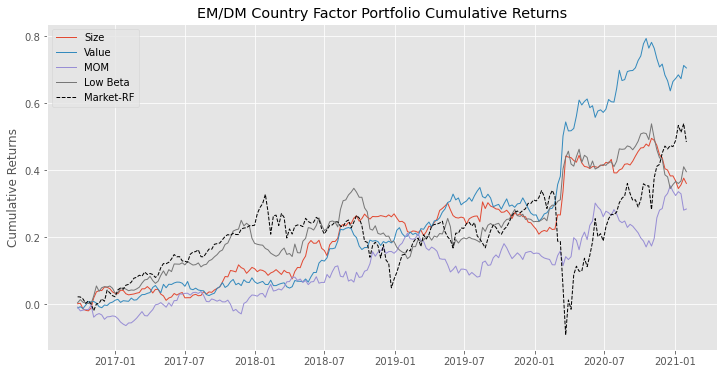

In [16]:
all_port_cum_ret_df = calc_cum_returns(all_port_rets)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-2]], \
          perf_bm=all_port_cum_ret_df['Mkt-RF_cum_ret'], label=['Size', 'Value', 'MOM', 'Low Beta', 'Mkt-RF'], \
          title='EM/DM Country Factor Portfolio Cumulative Returns')

In [17]:
all_perf = []
for col in all_port_rets.columns[:-1]:
    perf_ = calc_performance(all_port_rets[col])
    all_perf.append(perf_)

perf_df = pd.DataFrame(all_perf, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = ['Size', 'Value', 'MOM', 'Low Beta', 'Mkt-RF'])
perf_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
Size,6.06,8.78,0.69,1.46,6.60,11.28,2016-05-15
Value,11.74,8.73,1.35,1.28,7.19,8.71,2020-12-20
MOM,5.87,9.83,0.60,0.41,1.48,10.79,2019-08-04
Low Beta,7.80,10.06,0.78,0.23,3.14,15.59,2019-02-03
Mkt-RF,8.49,17.57,0.48,-1.17,9.24,32.18,2020-03-22


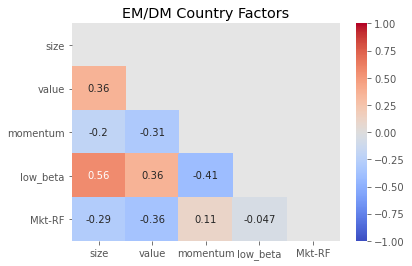

In [18]:
# Correlations of country factors
corr_country_df = plot_corr(all_port_rets.iloc[:,:-1], 'EM/DM Country Factors')
corr_country_df

In [19]:
all_port_rets.to_pickle(OUTPUT_DIR + 'equity_DM_country_factors.pkl')